<a href="https://colab.research.google.com/github/evolvej2/financial_risk/blob/main/value_at_risk_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estimating Value at Risk for a Financial Asset

This notebook calculates the Value at Risk (VaR) for a financial asset using three different methods:
1. The historical method
2. The variance-covariance method
3. Monte Carlo simulation

### Key Modeling Components and Assumptions

The objective of calculating Value at Risk (VaR) is to estimate the potential loss an investor may face over a certain time horizon, either as a proportion of the invested capital or as an absolute amount, in a worst-case scenario. VaR is expressed with a confidence level, typically 95% or 99%. For example, with a 95% confidence level, a VaR of €500 dollars on a €2000 investment means that, in 95 out of 100 trading days, the loss will not exceed €500.  

VaR calculations:
* depend on the chosen **time frame** (e.g. daily, weekly, or monthly returns).
* assumes that returns for the specified period are independent and identically distributed (e.g. volatility stable over time and no autocorrelation).
* considers the periodic return, i.e. the profit/loss made of an investment over the chose time frame. For instance, an investor buys $1000 worth of shares one day and sells them the next. The approach does hence not account for compounding returns across multiple days.  

For this notebook, we focus on **daily VaR** by analyzing daily percentage returns.

---



### Overview of the Methods

1. **The Historical Method**  
   This non-parametric approach calculates VaR by directly analyzing the historical return distribution. The historical returns are ranked, and the VaR is determined as the return at the chosen percentile (e.g. the 5th percentile for a 95% confidence level). This method assumes that past returns are representative of future risk without assuming returns follow any particular probability distribution.

2. **The Variance-Covariance Method**  
   This parametric method assumes that returns are normally distributed. VaR is calculated using the portfolio’s mean return $\mu$ and standard deviation $\sigma$. For a 95% confidence level, the formula is:
   $\text{VaR} = \mu - z \cdot \sigma$ where $z$ is the one-tailed critical value from the standard normal distribution (e.g. $z = 1.645$ for 95% confidence). This method is computationally efficient but may not capture extreme risks if the returns deviate significantly from normality (e.g. fat tails).

3. **Monte Carlo Simulation**  
   This method generates a large number of hypothetical return scenarios based on the statistical properties of historical returns (e.g. mean and standard deviation). Random numbers are drawn from a distribution (e.g., normal or another fitted distribution), and the portfolio’s potential losses are calculated for each scenario. The VaR is determined as the loss at the desired percentile of the simulated loss distribution. This method is flexible and can handle complex distributions but may require a large number of simulations.

---

This notebook will implement all three methods and compare their results to illustrate their differences and assumptions.


In [1]:
#import packages
import yfinance as yf
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import datetime as dt
import matplotlib.pyplot as plt
import tabulate
import seaborn as sns

###Retrieve and calculate return data

Steps:


1.   retrieve data on Price from an example stock
2.   calculate the daily fractional return
3. visualize price over time



,Price,Volume,Return
Date,,,
2023-01-03 00:00:00-05:00,235.711716,25740000,NaN
2023-01-04 00:00:00-05:00,225.400925,50623400,-4.374323
2023-01-05 00:00:00-05:00,218.720551,39585600,-2.963774
2023-01-06 00:00:00-05:00,221.298264,43613600,1.178542
2023-01-09 00:00:00-05:00,223.452881,27369800,0.973626


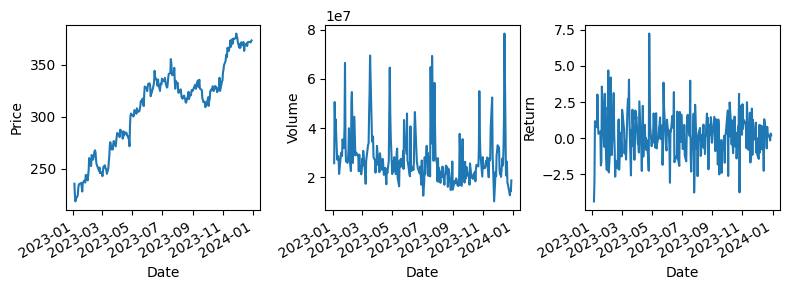

In [2]:
#choose a stock Microsoft (labeled msft)
stock_example = yf.Ticker('msft')

#set the investment level
investment = 1000

#retrieve daily data from the whole of 2023
startDate = dt.datetime(2023,1,1)
endDate = dt.datetime(2023,12,31)
data = stock_example.history(start=startDate, end = endDate)[['Close','Volume']]
data.rename(columns={'Close':'Price'}, inplace = True)


#calculate daily returns as percentage return
returns = data['Price'].pct_change()*100

#calculate the returns of the investment and add to the dataframe
returns = returns
data['Return'] = returns

#display the data
display(data.head(5))


#plot the price, return and volume data
fig, ax = plt.subplots(1,3, figsize=(8,3))
sns.lineplot(data['Price'], ax=ax[0])
sns.lineplot(data['Volume'], ax=ax[1])
sns.lineplot(data['Return'], ax=ax[2])
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()



###Calculate Value at Risk (VaR) using the historical method

Steps:

1.   sort the historical percentage returns
2.   calculate the rank of the day corresponding to the chosen
 confidence levels (95% and 99%)
3.   retrieve the percentage returns of those days
4.  for comparison, calculate VaR in terms of percentage change and absolute dollar change and print
5.   visualize the result



Value at Risk 95% :            -2.312 %
Value at Risk 99%:             -3.751 %




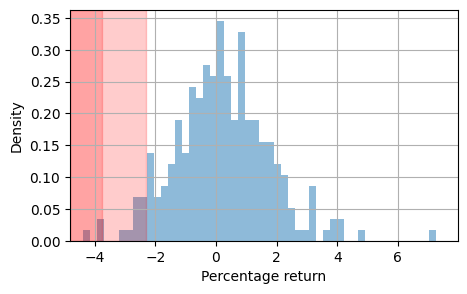

In [3]:
#sort the historical percentage returns
sorted_returns = returns.sort_values()

#calculate the rank corresponding to 95% confidence
rank_95 = round(len(sorted_returns)*0.05)
#calculate the rank corresponding to 95% confidence
rank_99 = round(len(sorted_returns)*0.01)

#pick these values
value_at_risk_95 = sorted_returns.iloc[rank_95]
value_at_risk_99 = sorted_returns.iloc[rank_99]

#print
print('Value at Risk 95% :           ', round(value_at_risk_95,3), '%')
print('Value at Risk 99%:            ', round(value_at_risk_99, 3), '%')


#visualize the distribution
fig, ax = plt.subplots(1,1, figsize=(5,3))
data['Return'].hist(bins=50, density=True, alpha=0.5, ax=ax, label = 'frequency')
ax.set_xlabel('Percentage return')
ax.set_ylabel('Density')


#shade the lowest 5% tail
ax.axvspan(data['Return'].min()*1.1, value_at_risk_95, color='red', alpha=0.2, label="Lowest 5%")

#shade the lowest 1% tail
ax.axvspan(data['Return'].min()*1.1, value_at_risk_99, color='red', alpha=0.2, label="Lowest 5%")

ax.set_xlim(data['Return'].min()*1.1, data['Return'].max()*1.1)
print('\n')

#store values for later comparison
value_at_risk_95_hist = value_at_risk_95
value_at_risk_99_hist = value_at_risk_99


###Calculate Value at Risk (VaR) using the variance-covariance method.

We consider daily returns over a year and based the simulations on the return data calculated for Microsoft, as in the example above.

Steps:
1.   calculate mean and standard deviation of the returns
2. use the point percentile for chosen confidence levels (95% and 99%) to calculate VaR in terms of fractional change
3. for comparison, calculate VaR in terms of percentage change and absolute dollar change and print
4. visualize using VaR in terms of percentage returns






In terms of percentage returns we obtain:
mean return:                    0.197 %
standard deviation of return:   1.582 %
Value at Risk 95% :            -2.406 %
Value at Risk 95% :            -2.406 %
Value at Risk 99%:             -3.484 %
----------------------------

In terms of fractional returns we obtain:
mean return:                    0.00197
standard deviation of return:   0.01582
Value at Risk 95% :            -0.02406
Value at Risk 99%:             -0.03484
----------------------------

In terms of absolute dollar returns on an investment of $10.000 we obtain:
mean return:                  $  19.7
standard deviation of return: $  158.2
Value at Risk 95% :           $ -240.6
Value at Risk 99%:            $ -348.4




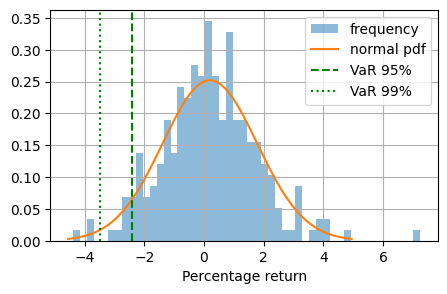

In [5]:
# mean returns for the stock in terms of percentage return
mean_return = returns.mean() #note that this method ignores the NaN at the start
std_return = returns.std(ddof = 1) #bessel correction

#calculate value at risk (VaR)

#calculate Z-score for a 95% and 99% one-sided confidence interval
z_score_95=1.645
z_score_99=2.326

value_at_risk_95=mean_return-z_score_95*std_return
value_at_risk_99=mean_return-z_score_99*std_return

#an alternative way to calculate the percentile
#value_at_risk_95 = norm.ppf(0.05, mean_return, std_return)
#value_at_risk_99 = norm.ppf(0.01, mean_return, std_return)

'''
Printing and visualising the results:
'''

#printing



print('\nIn terms of percentage returns we obtain:')
print('mean return:                   ', round(mean_return,3), '%')
print('standard deviation of return:  ', round(std_return,3), '%')
print('Value at Risk 95% :           ', round(value_at_risk_95,3), '%')
print('Value at Risk 95% :           ', round(low_lim,3), '%')
print('Value at Risk 99%:            ', round(value_at_risk_99, 3), '%')

print('----------------------------')
print('\nIn terms of fractional returns we obtain:')
print('mean return:                   ', round(mean_return/100, 5))
print('standard deviation of return:  ', round(std_return/100, 5))
print('Value at Risk 95% :           ', round(value_at_risk_95/100, 5))
print('Value at Risk 99%:            ', round(value_at_risk_99/100, 5))

print('----------------------------')
print('\nIn terms of absolute dollar returns on an investment of $10.000 we obtain:')
print('mean return:                  $ ', round(mean_return*10000/100,1))
print('standard deviation of return: $ ', round(std_return*10000/100,1))
print('Value at Risk 95% :           $', round(value_at_risk_95*10000/100,1))
print('Value at Risk 99%:            $', round(value_at_risk_99*10000/100,1))
print('\n')

#visualize for percentage returns:

fig, ax = plt.subplots(1,1, figsize=(5,3))
data['Return'].hist(bins=50, density=True, alpha=0.5, ax=ax, label = 'frequency')
ax.set_xlabel('Percentage return')

return_linspace = np.linspace(mean_return - 3*std_return, mean_return + 3*std_return, 200)
ax.plot(return_linspace, scipy.stats.norm.pdf(return_linspace, mean_return, std_return), label ='normal pdf')

ax.axvline(x = value_at_risk_95, color = 'g', linestyle = 'dashed', label = 'VaR 95%')
ax.axvline(x = value_at_risk_99, color = 'g', linestyle = 'dotted', label = 'VaR 99%' )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.show()

#store values for later comparison
value_at_risk_95_var = value_at_risk_95
value_at_risk_99_var = value_at_risk_99

###Estimating Value at Risk using Monte-Carlo simulations

We consider daily percentage returns over a year and based the simulations on the return data calculated for Microsoft, as in the examples above.

1. Construct a probability distribution from which to draw random returns. In this case we assume a normal pdf with mean and std from our return data.
2. Run one simulation in which we a) draw N random returns and b)
calculate the VaR at 95% and 99% using the historical method.
3. Repeat this 1000 times.
4. Summarize by calculating the mean and 95% confidence interval of the simulated VaR.

In [16]:
#set number of simulation runs
number_runs = 1000

#remove any NaN from the return data
returns = returns.dropna()

#estimate mean and std percentage return from the return data
mean_return = returns.mean()
std_return = returns.std(ddof = 1)

#calculate number of days in the data set
number_days=len(returns)

#check if it is around 252
print('Number of market days:', number_days)

#pre-allocate arrays for storing the estimated values at risk
value_at_risk_95 = np.zeros(number_runs)
value_at_risk_99 = np.zeros(number_runs)

for i in range(number_runs):
  #pick random numbers for every market day in the year
  random_return = np.random.normal(mean_return, std_return, number_days)
  #calculate the value at risk at 95% confidence level using percentile()
  value_at_risk_95[i] = np.percentile(random_return, 5)
  #calculate the value at risk at 95% confidence level using np.percentile()
  value_at_risk_99[i] = np.percentile(random_return, 1)

mean_estimated_VaR95 = value_at_risk_95.mean()
mean_estimated_VaR99 = value_at_risk_99.mean()

std_estimated_VaR95 = value_at_risk_95.std()
std_estimated_VaR99 = value_at_risk_99.std()



#calculate a 95% confidence interval of our simulation result
#
#(note that this is a point estimate of
#the mean Var95 and Var99 values obtained from our simulations
#with a two-sided confidence interval, not to be confused with
#the 95 and 99 one-sided confidence interval limits in the
#calculation of the VaRs)

#set z-score for a 95% two-sided confidence interval
z_score=1.96

estimated_standard_error_VaR95 = std_estimated_VaR95/np.sqrt(number_runs)
estimated_standard_error_VaR99 = std_estimated_VaR99/np.sqrt(number_runs)

#compute the lower and upper limits of the 95% confidence interval
low_lim_VaR95 = mean_estimated_VaR95 - z_score*estimated_standard_error_VaR95
up_lim_VaR95  = mean_estimated_VaR95 + z_score*estimated_standard_error_VaR95
low_lim_VaR99 = mean_estimated_VaR99 - z_score*estimated_standard_error_VaR99
up_lim_VaR99  = mean_estimated_VaR99 + z_score*estimated_standard_error_VaR99

#store values for later comparison

#present the results of the Monte Carlo simulation

print('----------------------------')
print("The Monte Carlo simulation with 1000 runs estimated:")
print("\nthe mean VaR95 to be", round(mean_estimated_VaR95,3))
print("with a 95% confidence interval of[", round(low_lim_VaR95,3), ",",round(up_lim_VaR95,3),"]")

print("\nand ")
print("\nthe mean VaR99 to be", round(mean_estimated_VaR99,3))
print("with a 95% confidence interval of[", round(low_lim_VaR99,3), ",",round(up_lim_VaR99,3),"]")
print("calculated using the standard error of the mean.")


#print the VaR results in the same format as above

print('\n----------------------------')
print('Value at Risk 95% :           ', round(mean_estimated_VaR95,3), '%')
print('Value at Risk 99%:            ', round(mean_estimated_VaR99, 3), '%')

value_at_risk_95_mc = mean_estimated_VaR95
value_at_risk_99_mc = mean_estimated_VaR99




Number of market days: 249
----------------------------
The Monte Carlo simulation with 1000 runs estimated:

the mean VaR95 to be -2.373
with a 95% confidence interval of[ -2.386 , -2.36 ]

and 

the mean VaR99 to be -3.349
with a 95% confidence interval of[ -3.369 , -3.328 ]
calculated using the standard error of the mean.

----------------------------
Value at Risk 95% :            -2.373 %
Value at Risk 99%:             -3.349 %


Comparison of results from the different methods

In [17]:
#print the VaR values from the different methods above:
print('Value at Risk 95%')
print('historical method:           ', round(value_at_risk_95_hist,3), '%')
print('variance-covariance method:  ', round(value_at_risk_95_var,3), '%')
print('Monte-Carlo method:          ', round(value_at_risk_95_mc,3), '%')
print('----------------------------')
print('Value at Risk 99%')
print('historical method:           ', round(value_at_risk_99_hist, 3), '%')
print('variance-covariance method:  ', round(value_at_risk_99_var, 3), '%')
print('Monte-Carlo method:          ', round(value_at_risk_99_mc, 3), '%')

Value at Risk 95%
historical method:            -2.312 %
variance-covariance method:   -2.406 %
Monte-Carlo method:           -2.373 %
----------------------------
Value at Risk 99%
historical method:            -3.751 %
variance-covariance method:   -3.484 %
Monte-Carlo method:           -3.349 %


##Notes:

### Periodic Returns

Periodic returns are central to VaR calculations and can be expressed in different ways. If we let $p_t$ denote the unit price of day $t$, and the number of units held as $N$ swe have:  
- **Fractional change**: $   \frac{p_{t+1}-p_t}{p_t}$
- **Percentage change**: $  100*\frac{p_{t+1}-p_t}{p_t}$
- **Absolute dollar change**: $  N* (p_{t+1}-p_t)$
- **Log returns**:   $ln(\frac{p_{t+1}}{p_t})$  

Log returns are often preferred for modeling because they allow for additive compounding over multiple periods and better approximate normality.

---

### Standard Deviation

The variance and standard deviation of returns are key components of VaR. Since we are working with a **sample** of historical prices, the Bessel correction is applied to calculate the sample variance:

$$
\sigma^2 = \frac{1}{N-1} \sum_{i=1}^{N} (p_i - \mu)^2
$$

Where:  
- $N$ is the number of observed periods (e.g., days),  
- $p_i$ is the return for period $i$, and  
- $\mu$ is the mean return.  

Note, that for datasets that cover the *entire population* i.e. the whole history of returns, the variance formula typically uses division by $N$ instead of $N-1$.  



